# Special Requests Regression With CatBoost

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from category_encoders import TargetEncoder
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import sys
import os
sys.path.append(os.path.abspath(".."))

c:\Users\Sebastijan\anaconda3\envs\hotel_management\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset Import

In [2]:
data = pd.read_parquet("../../data/hotel_booking_optimized.parquet")
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,Transient,98.0,0,1,Check-Out,2015-07-03,Linda Hines,LHines@verizon.com,713-226-5883,************5498


## Preparing the Data

In [3]:
# A function to map week number to season
def week_to_season(week):
    if 10 <= week <= 21:
        return 'Spring'
    elif 22 <= week <= 34:
        return 'Summer'
    elif 35 <= week <= 47:
        return 'Fall'
    else:
        return 'Winter'

data["total_stay"] = data["stays_in_weekend_nights"] + data["stays_in_week_nights"]
data["arrival_season"] = data["arrival_date_week_number"].apply(week_to_season)

In [4]:
numeric_features = [
    'stays_in_weekend_nights',
    'stays_in_week_nights',
    'adults', 'children', 'babies',
    'previous_cancellations', 'previous_bookings_not_canceled',
    'booking_changes',
    'required_car_parking_spaces',
    'total_stay'
]

categorical_features = [
    'hotel',
    'arrival_date_month',
    'meal',
    'country',
    'market_segment',
    'distribution_channel',
    'reserved_room_type',
    'deposit_type',
    'agent',
    'customer_type',
    'arrival_season'
]

In [5]:
for col in categorical_features:
    data[col] = data[col].astype(str).fillna('missing')

## Train/Test Split

In [6]:
X = data[numeric_features + categorical_features].copy()
y = data["total_of_special_requests"].copy()

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.15, random_state=42
)  # 0.15 x 0.8 = 0.12   

## First Model

### Preparation

In [7]:
class SklearnCatBoost(CatBoostRegressor, BaseEstimator):
    pass

cb = SklearnCatBoost(
    loss_function="RMSE", 
    verbose=100, 
    random_seed=42,
    task_type="GPU",
    devices='0'
)

In [8]:
param_dist_1 = {
    'iterations': [500, 1000, 1500, 2000],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'bagging_temperature': [0, 0.3, 0.7, 1],
    'random_strength': [0, 1, 3, 5, 10]
}

In [9]:
fit_params_1 = {
    'cat_features': categorical_features,
    'eval_set': (X_val, y_val),
    'early_stopping_rounds': 100,
    'use_best_model': True # for clarity
}

In [10]:
random_search_1 = RandomizedSearchCV(
    estimator=cb,
    param_distributions=param_dist_1,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=1
)

### Search

In [11]:
random_search_1.fit(X_train, y_train, **fit_params_1)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
0:	learn: 0.7874973	test: 0.7889511	best: 0.7889511 (0)	total: 25.7ms	remaining: 25.6s
100:	learn: 0.7121486	test: 0.7127698	best: 0.7127698 (100)	total: 1.25s	remaining: 11.1s
200:	learn: 0.6947042	test: 0.6953265	best: 0.6953265 (200)	total: 2.56s	remaining: 10.2s
300:	learn: 0.6875059	test: 0.6881495	best: 0.6881495 (300)	total: 3.91s	remaining: 9.09s
400:	learn: 0.6830010	test: 0.6838141	best: 0.6838141 (400)	total: 5.3s	remaining: 7.92s
500:	learn: 0.6797750	test: 0.6807366	best: 0.6807366 (500)	total: 6.63s	remaining: 6.6s
600:	learn: 0.6772555	test: 0.6783196	best: 0.6783196 (600)	total: 7.97s	remaining: 5.29s
700:	learn: 0.6752115	test: 0.6764184	best: 0.6764184 (700)	total: 9.33s	remaining: 3.98s
800:	learn: 0.6736208	test: 0.6749355	best: 0.6749355 (800)	total: 10.7s	remaining: 2.65s
900:	learn: 0.6721717	test: 0.6735929	best: 0.6735929 (900)	total: 12.1s	remaining: 1.33s
999:	learn: 0.6710385	test: 0.6725825	best: 

,estimator,"SklearnCatBoo..., verbose=100)"
,param_distributions,"{'bagging_temperature': [0, 0.3, ...], 'depth': [4, 6, ...], 'iterations': [500, 1000, ...], 'l2_leaf_reg': [1, 3, ...], ...}"
,n_iter,20
,scoring,'neg_root_mean_squared_error'
,n_jobs,1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [12]:
random_search_1.best_params_

{'random_strength': 0,
 'learning_rate': 0.05,
 'l2_leaf_reg': 7,
 'iterations': 1000,
 'depth': 10,
 'bagging_temperature': 0}

In [13]:
cat_boost_1 = random_search_1.best_estimator_
cat_boost_1

,iterations,1000
,learning_rate,0.05
,depth,10
,l2_leaf_reg,7
,loss_function,'RMSE'
,random_seed,42
,verbose,100
,random_strength,0
,bagging_temperature,0
,task_type,'GPU'
,devices,'0'


### Evaluation

In [14]:
y_pred_1 = cat_boost_1.predict(X_test)

In [15]:
rmse_1 = np.sqrt(mean_squared_error(y_test, y_pred_1))
mae_1 = mean_absolute_error(y_test, y_pred_1)
r2_1 = r2_score(y_test, y_pred_1)

print("First model evaluation:")
print(f"RMSE: {rmse_1:.2f}")
print(f"MAE:  {mae_1:.2f}")
print(f"R²:   {r2_1:.3f}")

First model evaluation:
RMSE: 0.65
MAE:  0.45
R²:   0.331


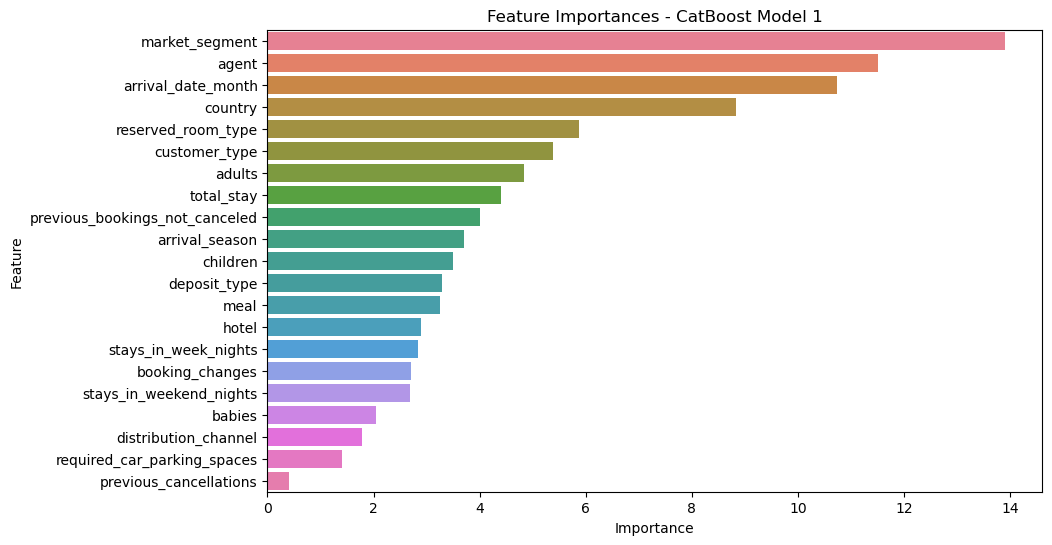

In [16]:
feature_importances_1 = cat_boost_1.get_feature_importance()
feature_names_1 = X_train.columns

df_imp_1 = pd.DataFrame({
    'Feature': feature_names_1,
    'Importance': feature_importances_1
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=df_imp_1, hue="Feature", legend=False)
plt.title("Feature Importances - CatBoost Model 1")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show();

## Second Model

### Preparation

In [18]:
param_dist_2 = {
    'iterations': [800, 1000, 1200],
    'depth': [9, 10],
    'learning_rate': [0.04, 0.05, 0.06, 0.07],
    'l2_leaf_reg': [6, 7, 8],
    'bagging_temperature': [0, 0.1],
    'random_strength': [0, 1]
}

In [19]:
fit_params_2 = {
    'cat_features': categorical_features,
    'eval_set': (X_val, y_val),
    'early_stopping_rounds': 100,
    "use_best_model": True # not needed, but explicitly states the intention
}

In [20]:
random_search_2 = RandomizedSearchCV(
    estimator=cb,
    param_distributions=param_dist_2,
    n_iter=40,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=1
)

### Search

In [21]:
random_search_2.fit(X_train, y_train, **fit_params_2)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
0:	learn: 0.7819987	test: 0.7834141	best: 0.7834141 (0)	total: 33.3ms	remaining: 39.9s
100:	learn: 0.6581625	test: 0.6678444	best: 0.6678444 (100)	total: 5.04s	remaining: 54.9s
200:	learn: 0.6453905	test: 0.6625607	best: 0.6625412 (197)	total: 12.4s	remaining: 1m 1s
300:	learn: 0.6369457	test: 0.6594522	best: 0.6594522 (300)	total: 19.4s	remaining: 57.9s
400:	learn: 0.6309839	test: 0.6580513	best: 0.6580513 (400)	total: 26.5s	remaining: 52.9s
500:	learn: 0.6257007	test: 0.6572212	best: 0.6572212 (500)	total: 33.5s	remaining: 46.8s
600:	learn: 0.6185460	test: 0.6565467	best: 0.6565467 (600)	total: 40.6s	remaining: 40.5s
700:	learn: 0.6136049	test: 0.6560790	best: 0.6560751 (698)	total: 47.7s	remaining: 34s
800:	learn: 0.6083645	test: 0.6558142	best: 0.6558107 (798)	total: 54.9s	remaining: 27.3s
900:	learn: 0.6037565	test: 0.6555187	best: 0.6554934 (889)	total: 1m 2s	remaining: 20.6s
1000:	learn: 0.5989515	test: 0.6551554	best

,estimator,"SklearnCatBoo..., verbose=100)"
,param_distributions,"{'bagging_temperature': [0, 0.1], 'depth': [9, 10], 'iterations': [800, 1000, ...], 'l2_leaf_reg': [6, 7, ...], ...}"
,n_iter,40
,scoring,'neg_root_mean_squared_error'
,n_jobs,1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [22]:
random_search_2.best_params_

{'random_strength': 0,
 'learning_rate': 0.06,
 'l2_leaf_reg': 7,
 'iterations': 1200,
 'depth': 10,
 'bagging_temperature': 0}

In [23]:
cat_boost_2 = random_search_2.best_estimator_
cat_boost_2

,iterations,1200
,learning_rate,0.06
,depth,10
,l2_leaf_reg,7
,loss_function,'RMSE'
,random_seed,42
,verbose,100
,random_strength,0
,bagging_temperature,0
,task_type,'GPU'
,devices,'0'


### Evaluation

In [24]:
y_pred_2 = cat_boost_2.predict(X_test)

In [25]:
rmse_2 = np.sqrt(mean_squared_error(y_test, y_pred_2))
mae_2 = mean_absolute_error(y_test, y_pred_2)
r2_2 = r2_score(y_test, y_pred_2)

print("Second model evaluation:")
print(f"RMSE: {rmse_2:.2f}")
print(f"MAE:  {mae_2:.2f}")
print(f"R²:   {r2_2:.3f}")

Second model evaluation:
RMSE: 0.65
MAE:  0.44
R²:   0.334


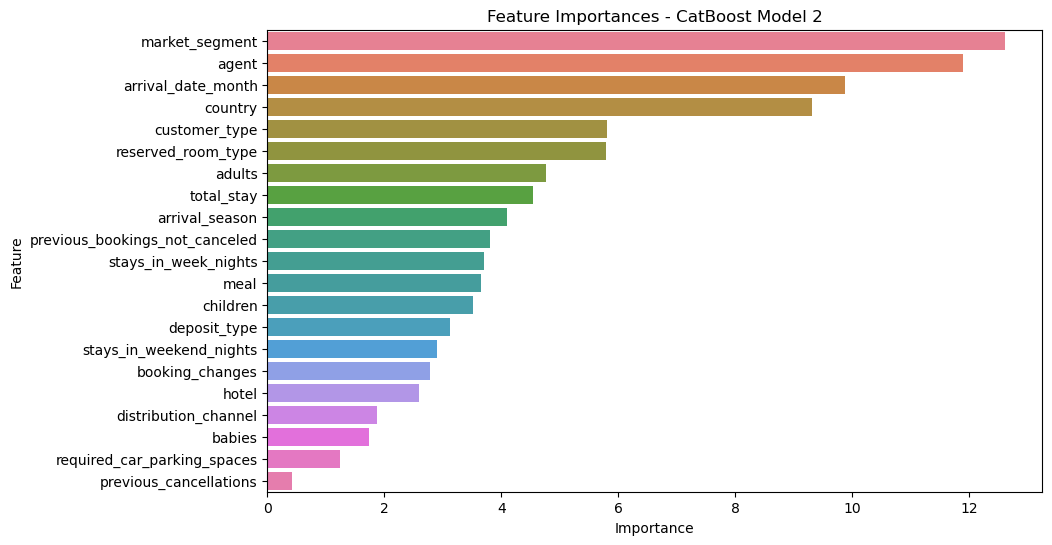

In [26]:
feature_importances_2 = cat_boost_2.get_feature_importance()
feature_names = X_train.columns

df_imp_2 = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances_2
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=df_imp_2, hue="Feature", legend=False)
plt.title("Feature Importances - CatBoost Model 2")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show();

## Final Model

### Retraining with train and val

In [8]:
final_model = CatBoostRegressor(
    loss_function="RMSE",
    verbose=100,
    random_seed=42,
    task_type="CPU", # Final model on CPU for production

    # Using the best parameters from the second random search
    iterations=1200,
    depth=10,
    learning_rate=0.06,
    l2_leaf_reg=7,
    random_strength=0,
    bagging_temperature=0,
)

In [9]:
final_model.fit(
    X_train_val, y_train_val,
    cat_features=categorical_features,
    early_stopping_rounds=100
)

0:	learn: 0.7816645	total: 240ms	remaining: 4m 47s
100:	learn: 0.6506652	total: 8.11s	remaining: 1m 28s
200:	learn: 0.6394314	total: 15.6s	remaining: 1m 17s
300:	learn: 0.6341896	total: 23.2s	remaining: 1m 9s
400:	learn: 0.6290793	total: 30.9s	remaining: 1m 1s
500:	learn: 0.6243879	total: 38.4s	remaining: 53.6s
600:	learn: 0.6198101	total: 45.8s	remaining: 45.7s
700:	learn: 0.6157674	total: 53.4s	remaining: 38s
800:	learn: 0.6121164	total: 1m	remaining: 30.4s
900:	learn: 0.6082774	total: 1m 8s	remaining: 22.8s
1000:	learn: 0.6045304	total: 1m 16s	remaining: 15.2s
1100:	learn: 0.6014497	total: 1m 24s	remaining: 7.56s
1199:	learn: 0.5973824	total: 1m 31s	remaining: 0us


### Preparing the final model for saving

In [10]:
required_columns = numeric_features + categorical_features
required_columns = [c for c in required_columns if c not in ["arrival_season", "total_stay"]]

In [11]:
class SpecialRequestsPredictor:
    def __init__(self, model, required_columns, categorical_features):
        self.model = model
        self.required_columns = required_columns
        self.categorical_features = categorical_features

    def week_to_season(self, week):
        if 10 <= week <= 21:
            return 'Spring'
        elif 22 <= week <= 34:
            return 'Summer'
        elif 35 <= week <= 47:
            return 'Fall'
        else:
            return 'Winter'

    def validate_schema(self, X):
        missing = [c for c in self.required_columns if c not in X.columns]
        if missing:
            raise ValueError(
                f"Model input schema violation. Missing columns: {missing}"
            )
        return X
    
    def _engineer_features(self, X):
        X = X.copy()
        X["total_stay"] = X["stays_in_weekend_nights"] + X["stays_in_week_nights"]
        X["arrival_season"] = X["arrival_date_week_number"].apply(self.week_to_season)
        for col in self.categorical_features:
            X[col] = X[col].astype(str).fillna('missing')
        return X

    def predict(self, X):
        X = self.validate_schema(X)
        X = self._engineer_features(X)
        X_processed = X[self.required_columns + ["total_stay", "arrival_season"]].copy()
        return self.model.predict(X_processed)

In [12]:
special_requests_predictor = SpecialRequestsPredictor(
    model=final_model,
    required_columns=required_columns,
    categorical_features=categorical_features
)

### Evaluating the final model

In [16]:
y_pred_final = final_model.predict(X_test)

In [17]:
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_final))
mae_final = mean_absolute_error(y_test, y_pred_final)
r2_final = r2_score(y_test, y_pred_final)

print("Final model evaluation:")
print(f"RMSE: {rmse_final:.2f}")
print(f"MAE:  {mae_final:.2f}")
print(f"R²:   {r2_final:.3f}")

Final model evaluation:
RMSE: 0.65
MAE:  0.44
R²:   0.339


In [13]:
joblib.dump(special_requests_predictor, "../../models/special_requests_predictor.joblib", compress=("lz4", 3))

['../../models/special_requests_predictor.joblib']

### Checking the feature importances

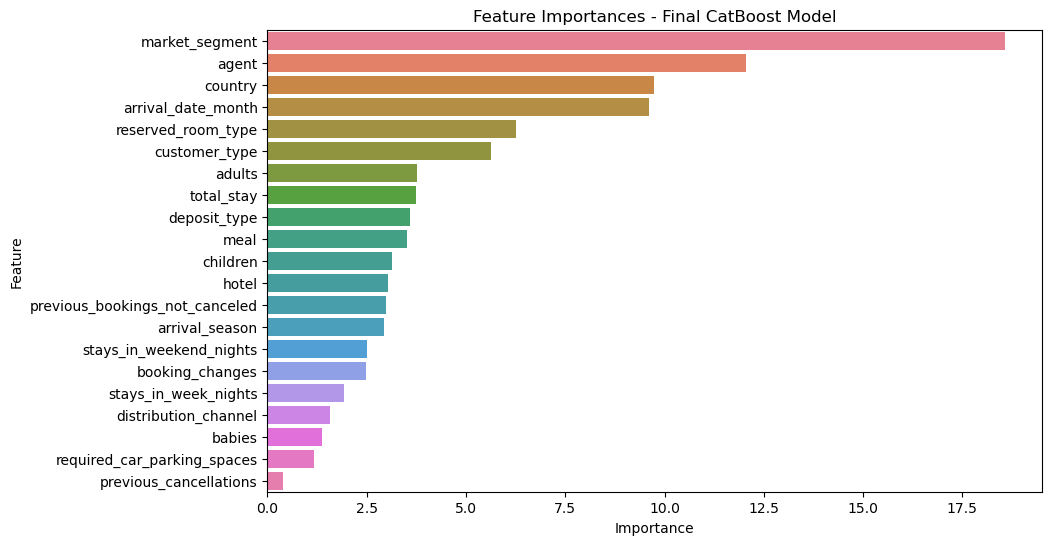

In [14]:
feature_importances_final = final_model.get_feature_importance()
feature_names_final = X_train_val.columns

df_imp_final = pd.DataFrame({
    'Feature': feature_names_final,
    'Importance': feature_importances_final
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=df_imp_final, hue="Feature", legend=False)
plt.title("Feature Importances - Final CatBoost Model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show();

### Saving the feature importances

#### Top 20

In [22]:
top_20_feature_importances = df_imp_final[:20]
top_20_feature_importances.to_csv("../../models/special_requests_feature_importances.csv", index=False)

### Saving the shap values

In [23]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)

In [24]:
mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_importance = pd.DataFrame({
    'Feature': X_test.columns,
    'SHAP_Importance': mean_abs_shap
}).sort_values(by='SHAP_Importance', ascending=False)

shap_importance

,Feature,SHAP_Importance
14,market_segment,0.146953
18,agent,0.075770
17,deposit_type,0.050311
2,adults,0.041098
13,country,0.038692
11,arrival_date_month,0.034129
16,reserved_room_type,0.031969
3,children,0.028310
19,customer_type,0.022167
9,total_stay,0.022068


#### Top 20

In [25]:
top_20_shap_importances = shap_importance[:20]
top_20_shap_importances.to_csv("../../models/special_requests_shap_importances.csv", index=False)

## END OF FILE